# Check version of Tensorflow and install required libraries
ref: https://github.com/raghakot/keras-vis/blob/master/examples/resnet/attention.ipynb


In [1]:
!ls
!pwd
!df -h
!pip install opencv-python
!python3 -c 'import tensorflow as tf; print(tf.__version__)'  # for Python 3
#!pip uninstall keras
#!pip install keras==2.1.5 -f
#!pip install keras-vis -f
!pip freeze

tmp		   train_terminal_too_much_enhancement.py  Untitled.ipynb
train		   train_terminal_use_image_in_memory.py   visualize.ipynb
train.ipynb	   train_terminal_v2.py
train_terminal.py  train_with_crop.py
/home/ec2-user/SageMaker/notebooks/robocar/customkeras
Filesystem      Size  Used Avail Use% Mounted on
devtmpfs         30G   68K   30G   1% /dev
tmpfs            30G     0   30G   0% /dev/shm
/dev/xvda1       74G   42G   33G  57% /
/dev/xvdf       4.8G  819M  3.8G  18% /home/ec2-user/SageMaker
distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
1.8.0
absl-py==0.4.1
alabaster==0.7.10
anaconda-client==1.6.14
anaconda-project==0.8.2
asn1crypto==0.24.0
astor==0.7.1
astroid==1.6.3
astropy==3.0.2
attrs==18.1.0
awscli==1.16.9
Babel==2.5.3
backcall==0.1.0
backports.shutil-get-terminal-size==1.0.0
beautifulsoup4==4.6.0
bitarray==0.8.1
bkcharts

In [ ]:
# model files

In [2]:
#!aws s3 sync s3://kyoungsu-robocar-nrt/traindata/blue/ /home/ec2-user/traindata/
!ls /home/ec2-user/SageMaker/model -alh


total 3.8M
drwxrwxr-x  2 ec2-user ec2-user 4.0K Oct 15 08:48 .
drwxr-xr-x 10 ec2-user ec2-user 4.0K Oct 15 05:36 ..
-rw-rw-r--  1 ec2-user ec2-user 3.8M Oct 15 08:18 blue-20181015-05-with-crop


# Load model file

In [3]:

from tensorflow.python.keras.models import Model, load_model
from vis.utils import utils
from vis.visualization import visualize_saliency, overlay
from keras import activations

model_path = "/home/ec2-user/SageMaker/model/car-model.pkl-blue-office-20181011_022147"
model_path = "/home/ec2-user/SageMaker/model/blue-20181015-05-with-crop"
# Build the ResNet50 network with ImageNet weights
model = load_model(model_path)


# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
#layer_idx = utils.find_layer_idx(model, 'conv2d_5')
layer_idx = utils.find_layer_idx(model, 'angle_out')


# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

Using TensorFlow backend.


In [4]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_in (InputLayer)             (None, 120, 160, 3)  0                                            
__________________________________________________________________________________________________
cropping2d_1 (Cropping2D)       (None, 75, 160, 3)   0           img_in[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 36, 78, 24)   1824        cropping2d_1[0][0]               
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 16, 37, 32)   19232       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [5]:
img1_path = '/home/ec2-user/SageMaker/traindata/tub_20181015_051246/3914_cam-image_array_.jpg'
img2_path = '/home/ec2-user/SageMaker/traindata/tub_20181015_051246/3954_cam-image_array_.jpg'
img1 = utils.load_img(img1_path)
img2 = utils.load_img(img2_path)

print(type(img1))

<class 'numpy.ndarray'>


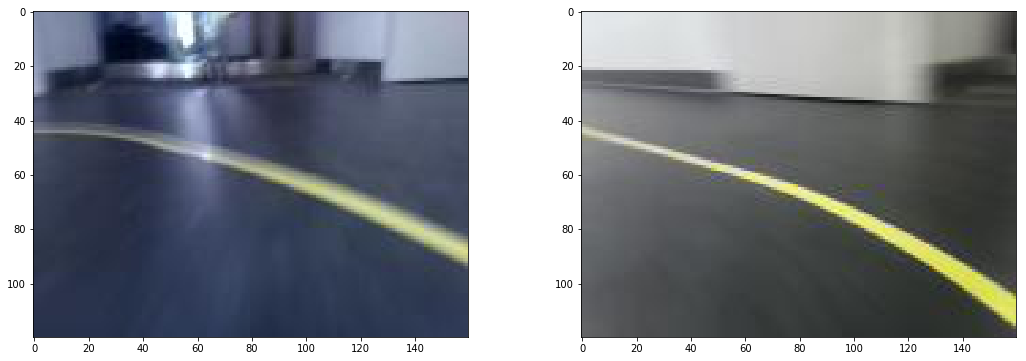

In [6]:

# should crop images
cropped_img1 = img1[0:][46:]
cropped_img2 = img2[0:][46:]
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

f, ax = plt.subplots(1, 2)
ax[0].imshow(img1)
ax[1].imshow(img2)
#ax[1][0].imshow(cropped_img1)
#ax[1][1].imshow(cropped_img2)

(120, 160, 3)
(120, 160, 3)


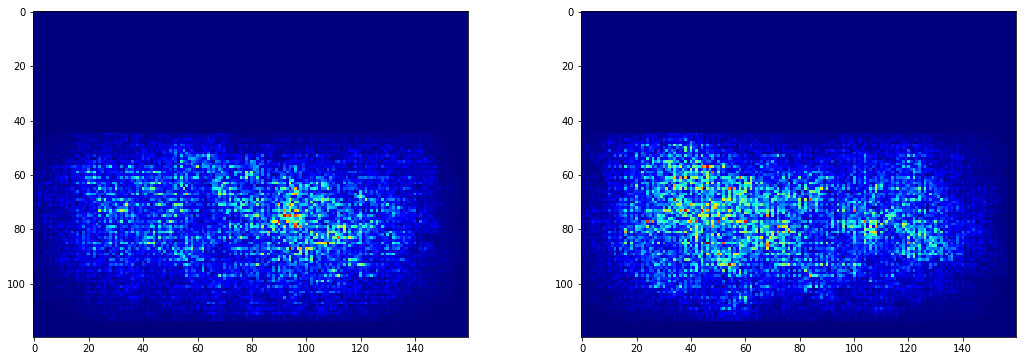

In [26]:
from vis.visualization import visualize_saliency, overlay
f, ax = plt.subplots(1, 2)

CMAP = "jet"

print(img1.shape)

print(img2.shape)

DEFINED_FILTER_INDICES=7
for i, img in enumerate([img1, img2]):    
    # 20 is the imagenet index corresponding to `ouzel`
    
    grads = visualize_saliency(model, layer_idx, filter_indices=DEFINED_FILTER_INDICES, seed_input=img)
    
    # visualize grads as heatmap
    ax[i].imshow(grads, cmap=CMAP)

<Figure size 1296x432 with 0 Axes>

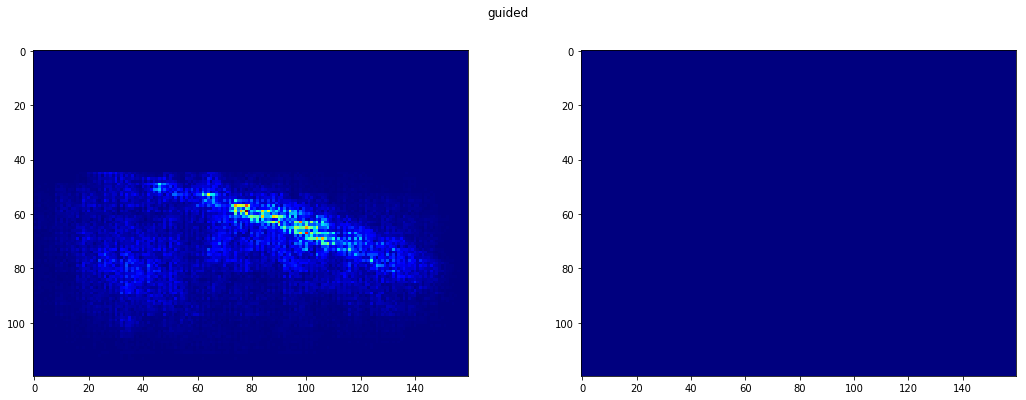

<Figure size 1296x432 with 0 Axes>

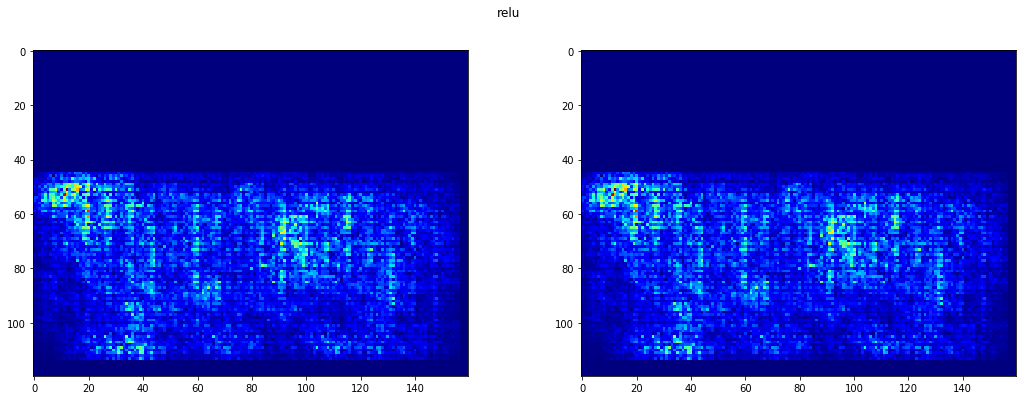

In [27]:
for modifier in ['guided', 'relu']:
    plt.figure()
    f, ax = plt.subplots(1, 2)
    plt.suptitle(modifier)
    for i, img in enumerate([img1, img2]):    
        # 20 is the imagenet index corresponding to `ouzel`
        grads = visualize_saliency(model, layer_idx, filter_indices=DEFINED_FILTER_INDICES, 
                                   seed_input=img, backprop_modifier=modifier)
        # Lets overlay the heatmap onto original image.    
        ax[i].imshow(grads, cmap=CMAP)

In [41]:
import numpy as np
import matplotlib.cm as cm
from vis.visualization import visualize_cam
import cv2


def draw_heatmap_by_layer(layer_name):
    penultimate_layer = utils.find_layer_idx(model, layer_name)
    for modifier in [None, 'guided', 'relu']:
        plt.figure()
        f, ax = plt.subplots(1, 2)
        plt.suptitle("vanilla" if modifier is None else modifier)
        for i, img in enumerate([img1, img2]):    
            # 20 is the imagenet index corresponding to `ouzel`
            grads = visualize_cam(model, layer_idx, filter_indices=DEFINED_FILTER_INDICES, 
                                  seed_input=img, penultimate_layer_idx=penultimate_layer,
                                  backprop_modifier=modifier)        
            # Lets overlay the heatmap onto original image.    
            jet_heatmap = np.uint8(cm.jet(grads)[...,:3] * 255)
            print("jet_heatmap.shape={}".format(jet_heatmap.shape))
            print("img.shape={}".format(img.shape))

            ov = jet_heatmap[..., 0];
            for j in range(1,2):
                ov = overlay(jet_heatmap[...,j], ov)

            res = cv2.resize(ov, dsize=(160, 75), interpolation=cv2.INTER_CUBIC)
            print("res.shape={}".format(res.shape))
            ax[i].imshow(overlay(res, img[45:,0:,0:]))


#Draw Convolution2D_1

jet_heatmap.shape=(120, 160, 3, 3)
img.shape=(120, 160, 3)
res.shape=(75, 160, 3)
jet_heatmap.shape=(120, 160, 3, 3)
img.shape=(120, 160, 3)
res.shape=(75, 160, 3)
jet_heatmap.shape=(120, 160, 3, 3)
img.shape=(120, 160, 3)
res.shape=(75, 160, 3)
jet_heatmap.shape=(120, 160, 3, 3)
img.shape=(120, 160, 3)
res.shape=(75, 160, 3)
jet_heatmap.shape=(120, 160, 3, 3)
img.shape=(120, 160, 3)
res.shape=(75, 160, 3)
jet_heatmap.shape=(120, 160, 3, 3)
img.shape=(120, 160, 3)
res.shape=(75, 160, 3)


<Figure size 1296x432 with 0 Axes>

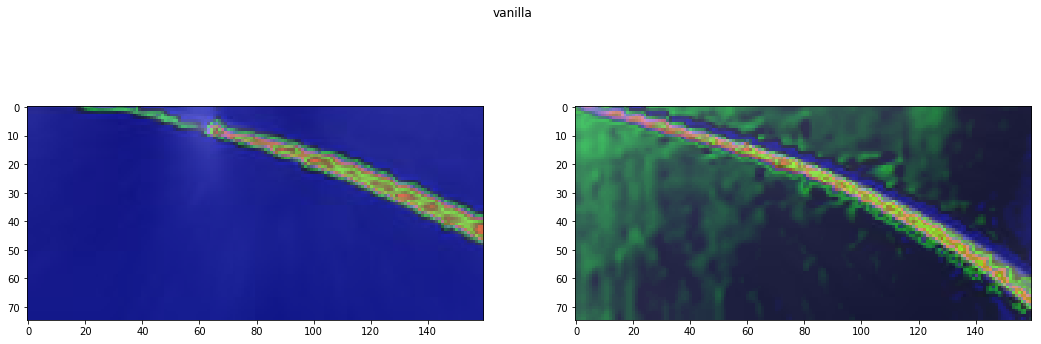

<Figure size 1296x432 with 0 Axes>

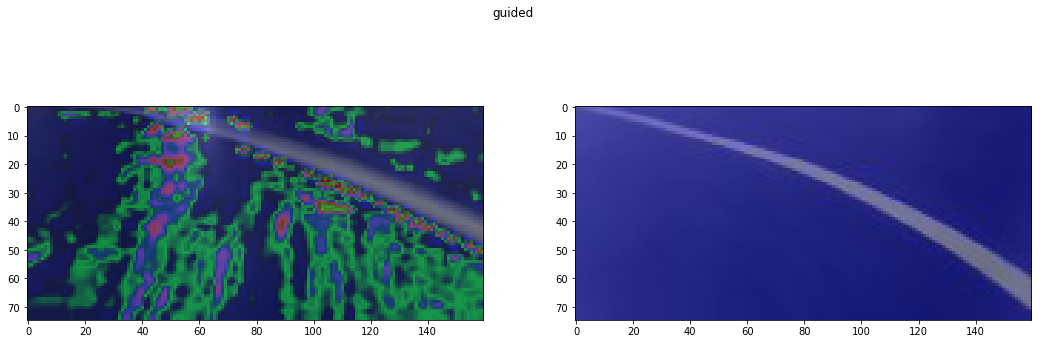

<Figure size 1296x432 with 0 Axes>

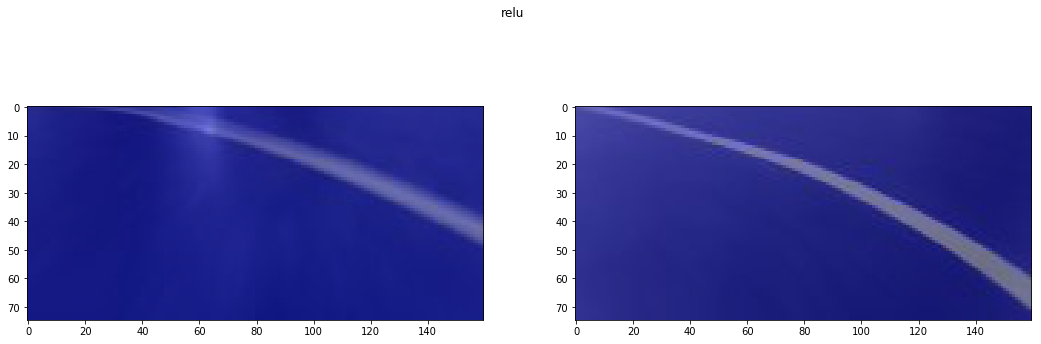

In [40]:
layer_name = "conv2d_1"
draw_heatmap_by_layer(layer_name)

#Draw Convolution2D_2

jet_heatmap.shape=(120, 160, 3, 3)
img.shape=(120, 160, 3)
res.shape=(75, 160, 3)
jet_heatmap.shape=(120, 160, 3, 3)
img.shape=(120, 160, 3)
res.shape=(75, 160, 3)
jet_heatmap.shape=(120, 160, 3, 3)
img.shape=(120, 160, 3)
res.shape=(75, 160, 3)
jet_heatmap.shape=(120, 160, 3, 3)
img.shape=(120, 160, 3)
res.shape=(75, 160, 3)
jet_heatmap.shape=(120, 160, 3, 3)
img.shape=(120, 160, 3)
res.shape=(75, 160, 3)
jet_heatmap.shape=(120, 160, 3, 3)
img.shape=(120, 160, 3)
res.shape=(75, 160, 3)


<Figure size 1296x432 with 0 Axes>

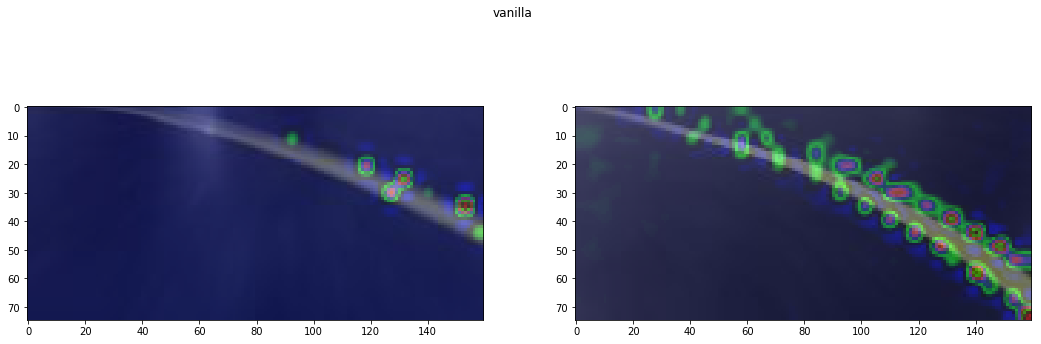

<Figure size 1296x432 with 0 Axes>

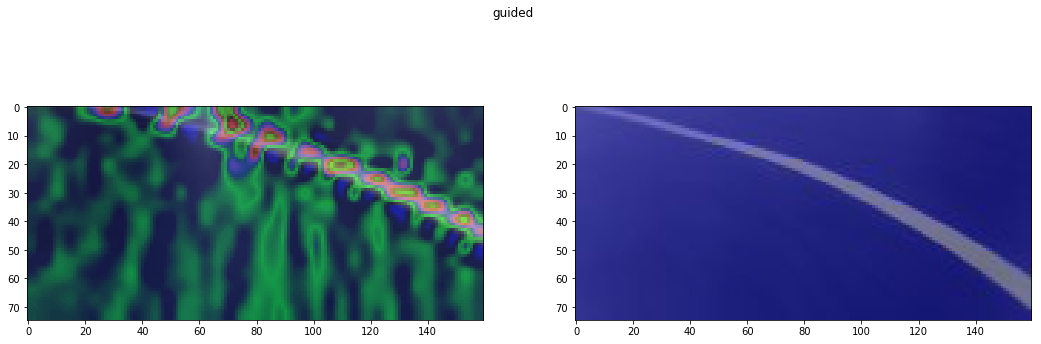

<Figure size 1296x432 with 0 Axes>

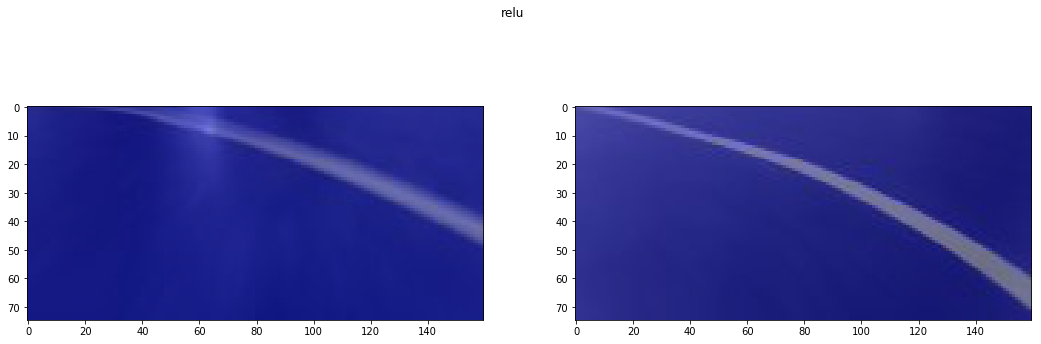

In [42]:
layer_name = "conv2d_2"
draw_heatmap_by_layer(layer_name)

#Draw Convolution2D_3

jet_heatmap.shape=(120, 160, 3, 3)
img.shape=(120, 160, 3)
res.shape=(75, 160, 3)
jet_heatmap.shape=(120, 160, 3, 3)
img.shape=(120, 160, 3)
res.shape=(75, 160, 3)
jet_heatmap.shape=(120, 160, 3, 3)
img.shape=(120, 160, 3)
res.shape=(75, 160, 3)
jet_heatmap.shape=(120, 160, 3, 3)
img.shape=(120, 160, 3)
res.shape=(75, 160, 3)
jet_heatmap.shape=(120, 160, 3, 3)
img.shape=(120, 160, 3)
res.shape=(75, 160, 3)
jet_heatmap.shape=(120, 160, 3, 3)
img.shape=(120, 160, 3)
res.shape=(75, 160, 3)


<Figure size 1296x432 with 0 Axes>

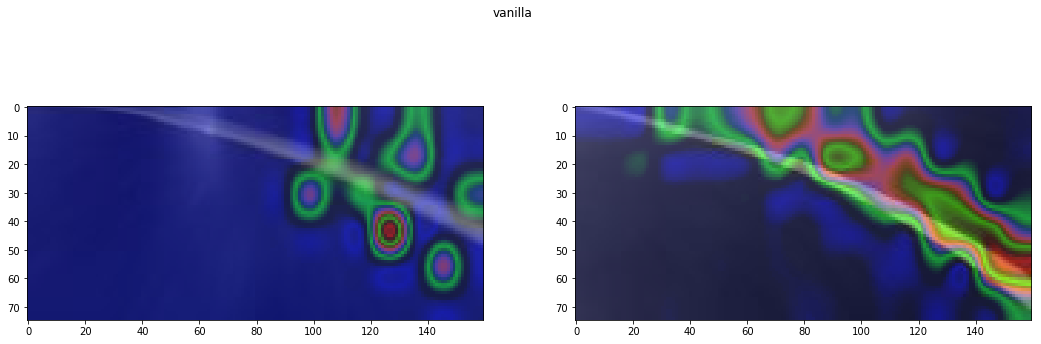

<Figure size 1296x432 with 0 Axes>

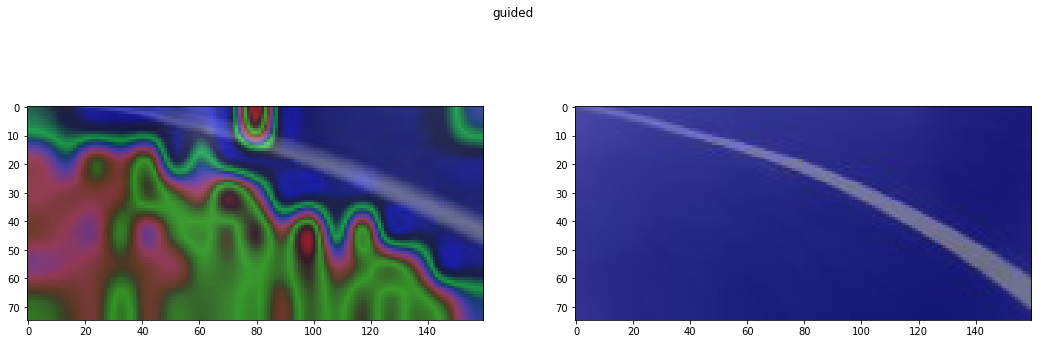

<Figure size 1296x432 with 0 Axes>

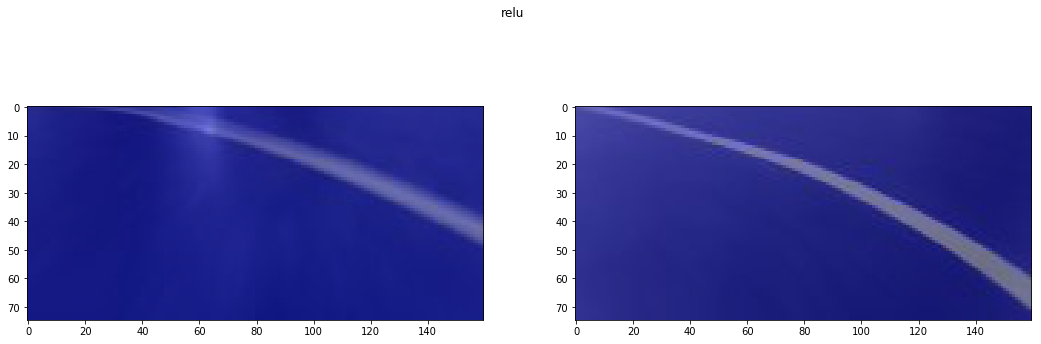

In [43]:
layer_name = "conv2d_3"
draw_heatmap_by_layer(layer_name)

#Draw Convolution2D_4

jet_heatmap.shape=(120, 160, 3, 3)
img.shape=(120, 160, 3)
res.shape=(75, 160, 3)
jet_heatmap.shape=(120, 160, 3, 3)
img.shape=(120, 160, 3)
res.shape=(75, 160, 3)
jet_heatmap.shape=(120, 160, 3, 3)
img.shape=(120, 160, 3)
res.shape=(75, 160, 3)
jet_heatmap.shape=(120, 160, 3, 3)
img.shape=(120, 160, 3)
res.shape=(75, 160, 3)
jet_heatmap.shape=(120, 160, 3, 3)
img.shape=(120, 160, 3)
res.shape=(75, 160, 3)
jet_heatmap.shape=(120, 160, 3, 3)
img.shape=(120, 160, 3)
res.shape=(75, 160, 3)


<Figure size 1296x432 with 0 Axes>

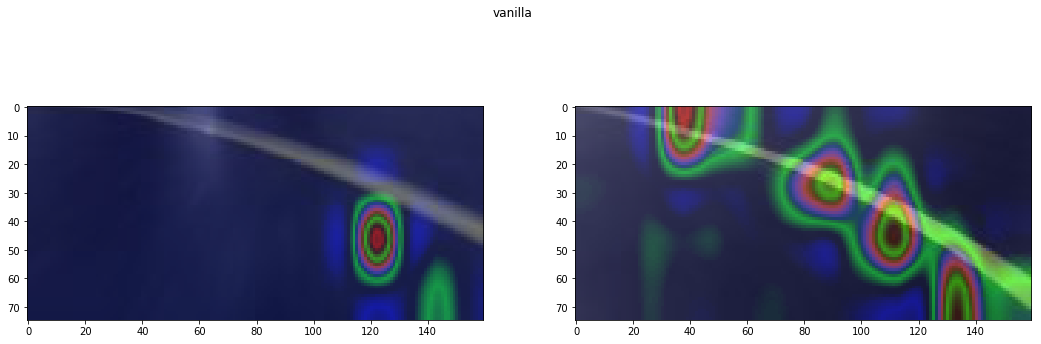

<Figure size 1296x432 with 0 Axes>

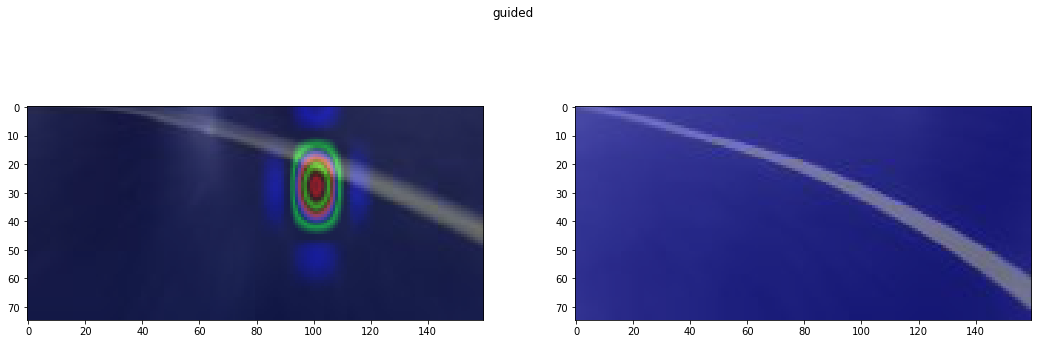

<Figure size 1296x432 with 0 Axes>

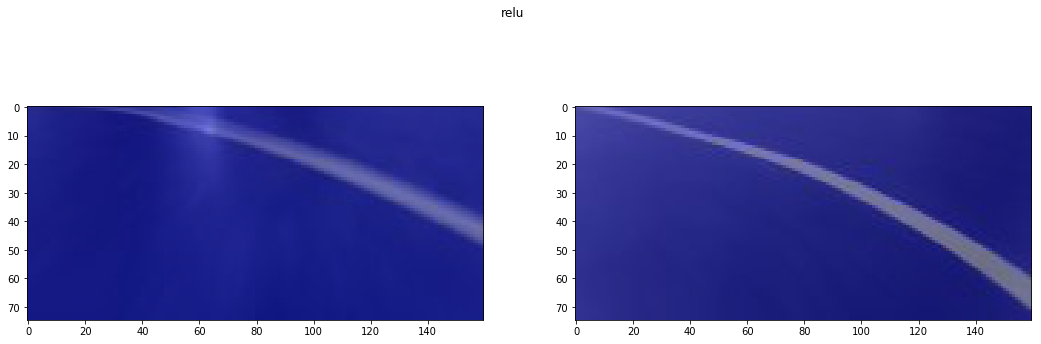

In [44]:
layer_name = "conv2d_4"
draw_heatmap_by_layer(layer_name)

#Draw Convolution2D_5

jet_heatmap.shape=(120, 160, 3, 3)
img.shape=(120, 160, 3)
res.shape=(75, 160, 3)
jet_heatmap.shape=(120, 160, 3, 3)
img.shape=(120, 160, 3)
res.shape=(75, 160, 3)
jet_heatmap.shape=(120, 160, 3, 3)
img.shape=(120, 160, 3)
res.shape=(75, 160, 3)
jet_heatmap.shape=(120, 160, 3, 3)
img.shape=(120, 160, 3)
res.shape=(75, 160, 3)
jet_heatmap.shape=(120, 160, 3, 3)
img.shape=(120, 160, 3)
res.shape=(75, 160, 3)
jet_heatmap.shape=(120, 160, 3, 3)
img.shape=(120, 160, 3)
res.shape=(75, 160, 3)


<Figure size 1296x432 with 0 Axes>

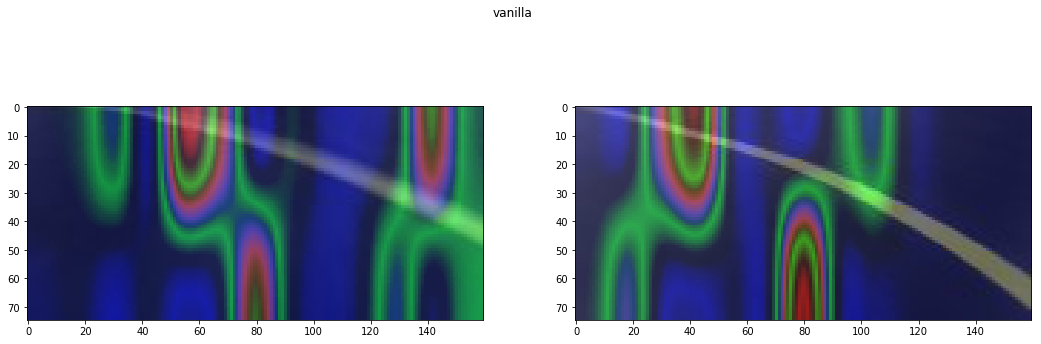

<Figure size 1296x432 with 0 Axes>

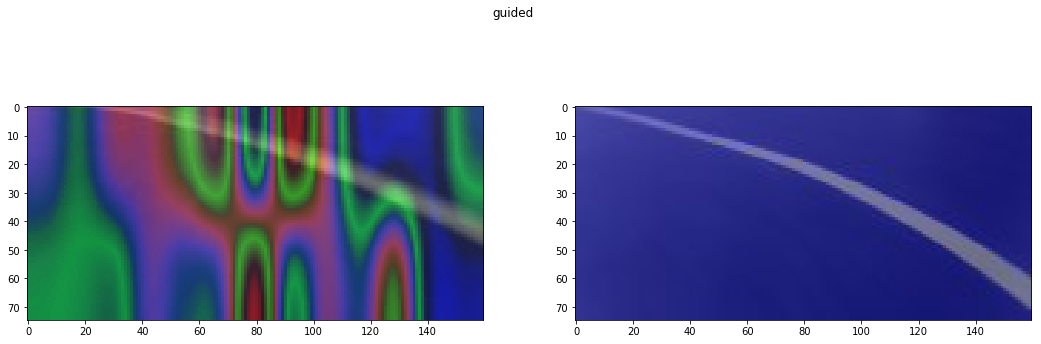

<Figure size 1296x432 with 0 Axes>

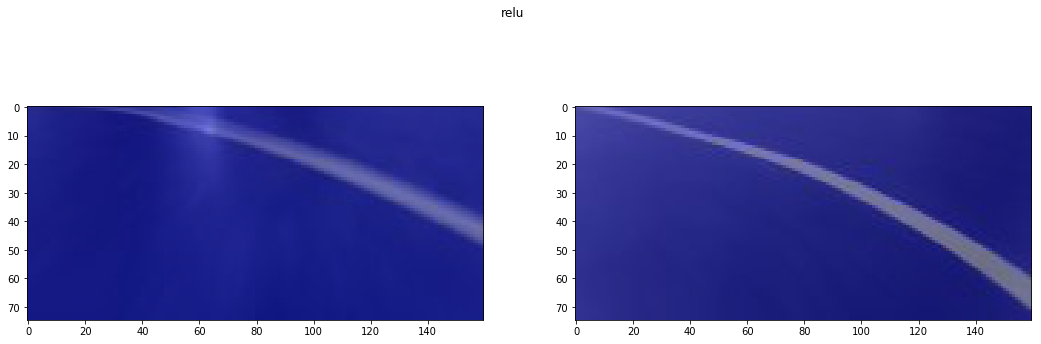

In [45]:
layer_name = "conv2d_5"
draw_heatmap_by_layer(layer_name)